# FairPredictor XGBoost Examples
This file contains demo code for an extended version of the example in Readme.md (additionally handling more fairness over multiple groups), and enforcing a range of fairness definition on COMPAS.

It is a modified version of [quickstart_autogluon.ipynb](./quickstart_autogluon.ipynb)

FairPredictor is a postprocessing approach for enforcing fairness, with support for a wide range of performance metrics and fairness criteria, and support for inferred attributes, i.e., it does not require access to protected attributes at test time. 
Under the hood, FairPredictor works by adjusting the decision boundary for each group individually. Where groups are not available, it makes use of inferred group membership to adjust decision boundaries.

The key idea underlying this toolkit is that for a wide range of use cases, the most suitable classifier should do more than maximize some form of accuracy.
We offer a general toolkit that allows different measures to be optimized and additional constraints to be imposed by tuning the behavior of a binary predictor on validation data.

For example, classifiers can be tuned to maximize performance for a wide range of metrics such as:

* Accuracy
* Balanced Accuracy
* F1 score
* MCC
* Custom utility functions

While also approximately satisfying a wide range of group constraints such as:

* Demographic Parity (The idea that positive decisions should occur at the same rates for all protected groups, for example for men at the same rate as for women)
* Equal Opportunity (The recall should be the same for all protected groups)
* Minimum recall constraints (The recall should be above a particular level for all groups)
* Minimum Precision constraints (The precision should be above a particular level for all groups)
* Custom Fairness Metrics

The full set of constraints and objectives can be seen in Readme.md 

In [1]:
# Load and train a baseline classifier

from oxonfair import dataset_loader, FairPredictor
from oxonfair import group_metrics as gm
import xgboost
import pandas as pd
import numpy as np


train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])

/opt/miniconda3/envs/ag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data['data'].shape,val_data['data'].shape,test_data['data'].shape

((24421, 14), (12210, 14), (12211, 14))

In [3]:
# Modify predictor to enforce fairness over the val_data with respect to groups given by the column 'sex'
fpredictor = FairPredictor(predictor,train_data, 'sex')
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy,gm.demographic_parity,0.02)


Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [4]:
# Evaluate on test data
fpredictor.predict(test_data)

array([0, 0, 0, ..., 0, 0, 0])

In [5]:
# Evaluate a range of performance measures, and compare against original classifier on test data
fpredictor.evaluate(test_data, verbose=True)

,original,updated
Accuracy,0.863156,0.845222
Balanced Accuracy,0.789951,0.759749
F1 score,0.694348,0.648176
MCC,0.609134,0.553450
Precision,0.745776,0.710612
Recall,0.649555,0.595825
ROC AUC,0.920422,0.813340


In [6]:
# Evaluate against a range of standard fairness definitions and compare against original classifier on test data
fpredictor.evaluate_fairness(test_data, verbose=True)

,original,updated
Statistical Parity,0.194998,0.008199
Predictive Parity,0.030115,0.359417
Equal Opportunity,0.114899,0.281616
Average Group Difference in False Negative Rate,0.114899,0.281616
Equalized Odds,0.098056,0.173844
Conditional Use Accuracy,0.058129,0.253697
Average Group Difference in Accuracy,0.104928,0.048980
Treatment Equality,0.332490,5.507195


In [7]:
# Evaluate a range of performance measures per group, and compare against original classifier on test data
fpredictor.evaluate_groups(test_data, verbose=True, return_original=True)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.863156           0.789951  0.694348  0.609134   
         0                   0.933300           0.766035  0.643799  0.618555   
         1                   0.828372           0.782878  0.702485  0.584003   
         Maximum difference  0.104928           0.016844  0.058685  0.034551   
updated  Overall             0.845222           0.759749  0.648176  0.553450   
         0                   0.877964           0.859046  0.599026  0.565086   
         1                   0.828984           0.751274  0.662802  0.574224   
         Maximum difference  0.048980           0.107772  0.063776  0.009138   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.745776  0.649555  0.920422          2922.0   
         0                    0.772152  0.552036  0.938214           442.0   
         1                    0.742037  0.666935  0.900383          2480.0   
         Maximum difference   0.030115  0.114899  0.037831          2038.0   
updated  Overall              0.710612  0.595825  0.813340          2922.0   
         0                    0.467089  0.834842  0.938214           442.0   
         1                    0.826506  0.553226  0.900383          2480.0   
         Maximum difference   0.359417  0.281616  0.037831          2038.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   
updated  Overall                     9289.0             0.239292   
         0                           3606.0             0.109190   
         1                           5683.0             0.303810   
         Maximum difference          2077.0             0.194620   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.208419  
         0                                   0.078063  
         1                                   0.273061  
         Maximum difference                  0.194998  
updated  Overall                             0.200639  
         0                                   0.195158  
         1                                   0.203357  
         Maximum difference                  0.008199

In [8]:
train_data, val_data, test_data = dataset_loader.adult('sex')
predictor=xgboost.XGBClassifier().fit(X=train_data['data'],y=train_data['target'])


In [9]:
fpredictor = FairPredictor(predictor,val_data,'race') 
# Maximize accuracy while enforcing that the demographic parity (the difference in positive decision rates between men and women is at most 0.02)
fpredictor.fit(gm.accuracy, gm.demographic_parity, .02)

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


In [10]:
# Unlike the previous case, we find that demographic parity is still high on test data, although it is improved.
fpredictor.evaluate_fairness(test_data)

,original,updated
Statistical Parity,0.125058,0.073183
Predictive Parity,0.013161,0.134499
Equal Opportunity,0.190932,0.079689
Average Group Difference in False Negative Rate,0.190932,0.079689
Equalized Odds,0.114792,0.047310
Conditional Use Accuracy,0.035533,0.101868
Average Group Difference in Accuracy,0.055388,0.041906
Treatment Equality,0.220158,1.118408


In [11]:
fpredictor.evaluate_fairness()

,original,updated
Statistical Parity,0.095165,0.016903
Predictive Parity,0.106777,0.142254
Equal Opportunity,0.191597,0.177972
Average Group Difference in False Negative Rate,0.191597,0.177972
Equalized Odds,0.118433,0.099354
Conditional Use Accuracy,0.070180,0.100921
Average Group Difference in Accuracy,0.053687,0.048322
Treatment Equality,0.394770,1.736889


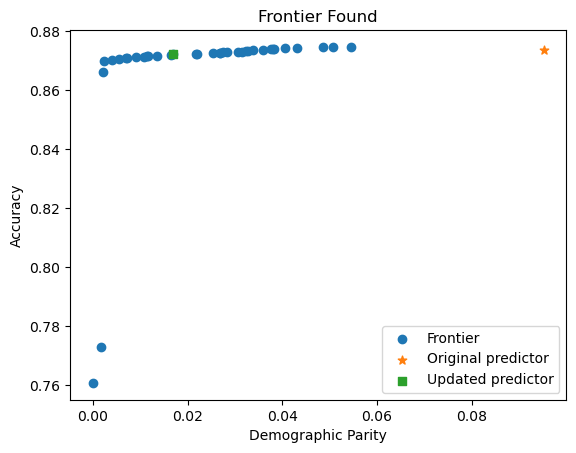

In [12]:
#To debug this, we can look at the Pareto Frontier of solutions considered, on the validation set
fpredictor.plot_frontier() 

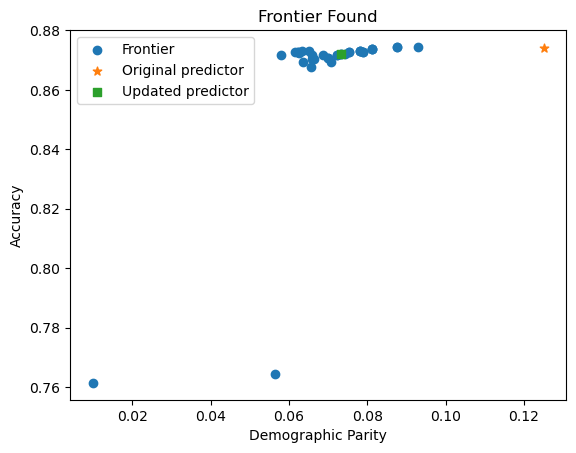

In [13]:
#and on the test set
fpredictor.plot_frontier(test_data) 

In [14]:
#We find that the demographic parity is very different on test data for a range of solutions found.
#By looking at the per group decomposition, we can find out why.
fpredictor.evaluate_groups(test_data)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.874212           0.800385  0.714816  0.638670   
         0                   0.863158           0.618671  0.380952  0.397779   
         1                   0.837838           0.805269  0.750000  0.634899   
         2                   0.939138           0.792021  0.686957  0.661844   
         3                   0.937500           0.797591  0.695652  0.668558   
         4                   0.867572           0.799523  0.715928  0.633844   
         Maximum difference  0.101300           0.186598  0.369048  0.270780   
updated  Overall             0.872001           0.792246  0.705039  0.629830   
         0                   0.884211           0.780854  0.645161  0.576493   
         1                   0.837838           0.794461  0.736842  0.633956   
         2                   0.913779           0.864642  0.673077  0.635721   
         3                   0.919643           0.787490  0.640000  0.595459   
         4                   0.867860           0.789262  0.706358  0.630176   
         Maximum difference  0.081805           0.083787  0.096842  0.059228   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.781250  0.658795  0.926794          2922.0   
         0                    0.800000  0.250000  0.879747            16.0   
         1                    0.810811  0.697674  0.919554           129.0   
         2                    0.797980  0.603053  0.960479           131.0   
         3                    0.800000  0.615385  0.973582            13.0   
         4                    0.778919  0.662362  0.922501          2633.0   
         Maximum difference   0.031892  0.447674  0.093835          2620.0   
updated  Overall              0.785865  0.639288  0.907573          2922.0   
         0                    0.666667  0.625000  0.879747            16.0   
         1                    0.848485  0.651163  0.919554           129.0   
         2                    0.580110  0.801527  0.960479           131.0   
         3                    0.666667  0.615385  0.973582            13.0   
         4                    0.802415  0.630839  0.922501          2633.0   
         Maximum difference   0.268374  0.186142  0.093835          2620.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9289.0             0.239292   
         0                             79.0             0.168421   
         1                            241.0             0.348649   
         2                           1052.0             0.110735   
         3                             99.0             0.116071   
         4                           7818.0             0.251938   
         Maximum difference          7739.0             0.237913   
updated  Overall                     9289.0             0.239292   
         0                             79.0             0.168421   
         1                            241.0             0.348649   
         2                           1052.0             0.110735   
         3                             99.0             0.116071   
         4                           7818.0             0.251938   
         Maximum difference          7739.0             0.237913   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.201785  
         0                                   0.052632  
         1                                   0.300000  
         2                                   0.083686  
         3                                   0.089286  
         4        

In [15]:
#The groups with the smallest Positive Prediction Rate (corresponding to American-Indian-Eskimo, and Asian-Pacific-Islander) 
# only have around 100 samples making it impossible to accurately evaluate demographic parity, while the
# group labelled 'Other' has even less data.
# Moreover, on validation data we find that there are less than 90 people identified as American-Indian-Eskimo, 
# meaning that it is not possible to predict if the positive prediction rate will hold on new data. 
fpredictor.evaluate_groups()

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.873464           0.800249  0.713942  0.636936   
         0                   0.888889           0.615909  0.363636  0.362441   
         1                   0.831978           0.759259  0.621951  0.514021   
         2                   0.927920           0.785367  0.678967  0.647838   
         3                   0.936170           0.833808  0.750000  0.716978   
         4                   0.867870           0.801810  0.720325  0.638056   
         Maximum difference  0.104192           0.217899  0.386364  0.354537   
updated  Overall             0.872072           0.791593  0.704502  0.629731   
         0                   0.880952           0.798295  0.594595  0.533002   
         1                   0.845528           0.736883  0.606897  0.517919   
         2                   0.907208           0.844999  0.678161  0.629830   
         3                   0.946809           0.936847  0.827586  0.802539   
         4                   0.868158           0.790250  0.709541  0.634121   
         Maximum difference  0.101280           0.199964  0.232992  0.284620   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.777733  0.659822  0.928441          2922.0   
         0                    0.666667  0.250000  0.900000            16.0   
         1                    0.614458  0.629630  0.879630            81.0   
         2                    0.793103  0.593548  0.947179           155.0   
         3                    0.818182  0.692308  0.951567            13.0   
         4                    0.783031  0.666918  0.926850          2657.0   
         Maximum difference   0.203724  0.442308  0.071937          2644.0   
updated  Overall              0.787648  0.637235  0.908668          2922.0   
         0                    0.523810  0.687500  0.900000            16.0   
         1                    0.687500  0.543210  0.879630            81.0   
         2                    0.611399  0.761290  0.947179           155.0   
         3                    0.750000  0.923077  0.951567            13.0   
         4                    0.810145  0.631163  0.926850          2657.0   
         Maximum difference   0.286335  0.379867  0.071937          2644.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     9288.0             0.239312   
         0                            110.0             0.126984   
         1                            288.0             0.219512   
         2                           1052.0             0.128418   
         3                             81.0             0.138298   
         4                           7757.0             0.255137   
         Maximum difference          7676.0             0.128153   
updated  Overall                     9288.0             0.239312   
         0                            110.0             0.126984   
         1                            288.0             0.219512   
         2                           1052.0             0.128418   
         3                             81.0             0.138298   
         4                           7757.0             0.255137   
         Maximum difference          7676.0             0.128153   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.203030  
         0                                   0.047619  
         1                                   0.224932  
         2                                   0.096106  
         3                                   0.117021  
         4        

## Fairness on COMPAS using Inferred Attributes

We demonstrate how to enforce a wide range of fairness definitions on the COMPAS dataset. This dataset records paroles caught violating the terms of parole. As it measures who was caught, it is strongly influenced by policing and environmental biases, and should not be confused with a measurement of who actually violated their terms of parole. See [this paper](https://datasets-benchmarks-proceedings.neurips.cc/paper/2021/file/92cc227532d17e56e07902b254dfad10-Paper-round1.pdf) for a discussion of its limitations and caveats. 
We use it because it is a standard fairness dataset that captures such strong differences in outcome between people identified as African-American and everyone else, that classifiers trained on this dataset violate most definitions of fairness.

As many of the ethnic groups are too small for reliable statistical estimation, we only consider differences is in outcomes between African-Americans vs. everyone else (labeled as other).
We load and preprocess the COMPAS dataset, splitting it into three roughly equal partitions of train, validation, and test:

In [16]:
#Generate two sets of training, validation and test, with race and without.
train, val, test = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, discard_groups=True, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})
train_g, val_g, test_g = dataset_loader.compas('race', train_proportion=0.66, test_proportion=0.33, replace_groups={'Hispanic':'Other', 'Native American':'Other', 'Asian':'Other'})

In [17]:
predictor = xgboost.XGBClassifier().fit(X=train_g['data'],y=train_g['target'])
predictor2 = xgboost.XGBClassifier().fit(X=train['data'],y=train['target'])
protected = xgboost.XGBClassifier().fit(X=train['data'],y=2*(train['groups']=='Other')+(train['groups']=='Caucasian'))

In [18]:
fpredictor=FairPredictor(predictor2, train, inferred_groups=protected)
fpredictor.fit(gm.accuracy, gm.demographic_parity, 0.025)

In [19]:
#However, instead we will show how a family of fairness measures can be individually optimized. 
# The following code plots a table showing the change in accuracy and the fairness measure on a held-out test set as we decrease
# the fairness measure to less than 0.025 for all measures except for disparate impact which we raise to above 0.975.
# We define a helper function for evaluation:

def evaluate(fpredictor, use_metrics, test):
    "Print a table showing the accuracy drop that comes with enforcing fairness"
    extra_metrics= {**use_metrics, 'accuracy':gm.accuracy}
    collect=pd.DataFrame(columns=['Measure (original)', 'Measure (updated)', 'Accuracy (original)', 'Accuracy (updated)'])
    for d in use_metrics.items():
        if d[1].greater_is_better is False:
            fpredictor.fit(gm.accuracy,d[1], 0.025)
        else:
            fpredictor.fit(gm.accuracy,d[1], 1-0.025)
        tmp=fpredictor.evaluate_fairness(test,metrics=extra_metrics)
        collect.loc[d[1].name]=np.concatenate((np.asarray(tmp.loc[d[1].name]), np.asarray(tmp.loc[gm.accuracy.name])), 0)
    return collect

In [20]:
train['data'].columns

Index(['sex', 'age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'age_cat', 'c_charge_degree'],
      dtype='object')

In [21]:
#We can now contrast the behavior of a fair classifier that relies on access to the protected
# attribtute at test time with one that infers it.

#Create a fair predictor object, using the attribute 'race' on validation data
fpredictor = FairPredictor(predictor, train_g, 'race')
#and then evaluate it
true_groups = evaluate(fpredictor, gm.clarify_metrics, test_g)

true_groups

Groups passed twice to fairpredictor both as part of the dataset and as an argument. The argument will be used.


,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.170373,0.063117,0.671849,0.663866
Disparate Impact,0.651723,0.892211,0.671849,0.663866
Average Group Difference in Conditional Acceptance Rate,0.392026,0.071445,0.671849,0.673950
Average Group Difference in Conditional Rejectance Rate,0.111950,0.034648,0.671849,0.674790
Average Group Difference in Accuracy,0.022351,0.025632,0.671849,0.667647
Average Group Difference in Recall,0.177895,0.069213,0.671849,0.671008
Average Group Difference in Acceptance Rate,0.040866,0.055503,0.671849,0.670168
Average Group Difference in Specificity,0.121835,0.057111,0.671849,0.674370
Average Group Difference in Rejection Rate,0.050291,0.038554,0.671849,0.668487
Treatment Equality,0.360054,0.052966,0.671849,0.673950


In [22]:
 # Now using infered attributes
#Note that group information is not present in train['data']
#But contained in train['groups'] as such we can not specify groups='race'
fpredictor2 = FairPredictor(predictor2, train, inferred_groups=protected) 
inferred = evaluate(fpredictor2, gm.clarify_metrics, test)
inferred

,Measure (original),Measure (updated),Accuracy (original),Accuracy (updated)
Demographic Parity,0.142173,0.107317,0.653361,0.624370
Disparate Impact,0.682094,0.731433,0.653361,0.618487
Average Group Difference in Conditional Acceptance Rate,0.287004,0.163108,0.653361,0.643697
Average Group Difference in Conditional Rejectance Rate,0.068234,0.063120,0.653361,0.649580
Average Group Difference in Accuracy,0.028167,0.026010,0.653361,0.650000
Average Group Difference in Recall,0.143907,0.130195,0.653361,0.628992
Average Group Difference in Acceptance Rate,0.059639,0.061339,0.653361,0.660924
Average Group Difference in Specificity,0.103289,0.089840,0.653361,0.645378
Average Group Difference in Rejection Rate,0.073389,0.062303,0.653361,0.655882
Treatment Equality,0.237167,0.160742,0.653361,0.646218


In [23]:
fpredictor2.evaluate_groups(test)

Accuracy  Balanced Accuracy  F1 score       MCC  \
         Groups                                                                
original Overall             0.653361           0.642428  0.580153  0.292805   
         African-American    0.641509           0.642416  0.636741  0.285145   
         Caucasian           0.658025           0.611952  0.476371  0.249640   
         Other               0.683761           0.639711  0.523605  0.292449   
         Maximum difference  0.042251           0.030463  0.160371  0.042809   
updated  Overall             0.646218           0.632754  0.558237  0.276979   
         African-American    0.634947           0.636885  0.616048  0.275896   
         Caucasian           0.654321           0.605603  0.461538  0.238911   
         Other               0.666667           0.616089  0.484581  0.247178   
         Maximum difference  0.031720           0.031282  0.154510  0.036986   

                             Precision    Recall   ROC AUC  Positive Count  \
         Groups                                                              
original Overall              0.639013  0.531221  0.700889          1073.0   
         African-American     0.664931  0.610845  0.701756           627.0   
         Caucasian            0.600000  0.394984  0.673311           319.0   
         Other                0.575472  0.480315  0.688607           127.0   
         Maximum difference   0.089459  0.215861  0.028445           500.0   
updated  Overall              0.638655  0.495806  0.688616          1073.0   
         African-American     0.671053  0.569378  0.693082           627.0   
         Caucasian            0.597015  0.376176  0.655683           319.0   
         Other                0.550000  0.433071  0.673703           127.0   
         Maximum difference   0.121053  0.193202  0.037399           500.0   

                             Negative Count  Positive Label Rate  \
         Groups                                                    
original Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   
updated  Overall                     1307.0             0.450840   
         African-American             592.0             0.514356   
         Caucasian                    491.0             0.393827   
         Other                        224.0             0.361823   
         Maximum difference           368.0             0.152533   

                             Positive Prediction Rate  
         Groups                                        
original Overall                             0.374790  
         African-American                    0.472518  
         Caucasian                           0.259259  
         Other                               0.301994  
         Maximum difference                  0.213259  
updated  Overall                             0.350000  
         African-American                    0.436423  
         Caucasian                           0.248148  
         Other                               0.284900  
         Maximum difference                  0.188275

In [24]:
from oxonfair import conditional_group_metrics as cgm
fpredictor2_cond = FairPredictor(predictor2, train, inferred_groups=protected,conditioning_factor='sex') 
fpredictor2_cond.fit(gm.accuracy,cgm.pos_pred_rate.diff,0.02)

In [25]:
fpredictor2_cond.evaluate(metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.738975,0.693406
Average Group Difference in Conditional Positive Prediction Rate,0.137529,0.019887


In [26]:
fpredictor2_cond.evaluate(test,metrics={'a':gm.accuracy,'b':cgm.pos_pred_rate.diff})


,original,updated
Accuracy,0.653361,0.626471
Average Group Difference in Conditional Positive Prediction Rate,0.136923,0.100760
